# Baseline
This is a baseline, which uses basic features of a graph and A to predict objective_energy.

In [1]:
from __future__ import print_function, division
%matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

from utils.dataset import Feat3Dataset, FeatTransformer
from sklearn.preprocessing import StandardScaler

### Feature engineering from graph

Extract basic features from graph. These features are input.

* average edge weight
* edge weight std
* number of nodes

Choose these feature because A is generated based on the max/min value of edge weight.

### Feature engineering from da_data

Extract information from da_data. **A** is treated as input. **Feasiblity** (whether da_distance != -1) and **objective energy** are the two targets to predict.

Column explanation is appended for reference:

- A: Penalty coefficient for the constraint QUBO, (Q_objective) + A(Q_constraint)
- Iteration number: The number of searches per anneal (int32 type).
- da_distance: The TSP tour length that we found using DA. If it’s not feasible, we return -1
- objective energy: When we solve the problem, we change the problem to an equivalent form to minimize the variance of the distance entries. The objective value that we obtained using this perturbation method is reported here.
- Objective_energy_unperturbed: Upon a solution from the DA, we can evaluate the energy function of the unperturbed data. When the problem is feasible, this is equal to da_distance.
- Column_constraint_energy:  There are 2 constraints in the TSP formulation, the column should sum to 1 and the row should sum to 1. This is the column qubo that we are reporting: \sum_j (\sum_i x_{ij} - 1)^2
- Row_constraint_energy: : \sum_i (\sum_j x_{ij} - 1)^2

### Data assembly  
Convert files into machine learning friendly format.  
Each Feat3Dataset dataset has eight fields

Input

- Average edge weight
- Std edge weight
- Number of nodes
- A

Target:

- Probability of Feasibility
- Average of Objective energy
- Std of Objective energy

Graph name from Feat3Dataset.getGroup


In [2]:
train_adj_path = './dataset/round0/adj/train/'
train_da_path = './dataset/round0/da/train/'

test_adj_path = './dataset/round0/adj/test/'
test_da_path = './dataset/round0/da/test/'

In [30]:
train_dataset = Feat3Dataset(adj_path=train_adj_path, da_path=train_da_path)
X = np.asarray([d['input'][0] for d in train_dataset])
Y = np.asarray([d['target'][0] for d in train_dataset])
scalerx = StandardScaler().fit(X)
scalery = StandardScaler().fit(Y)
transform = FeatTransformer(scalerx, scalery)
train_dataset = Feat3Dataset(adj_path=train_adj_path, da_path=train_da_path, transform=transform)

test_dataset = Feat3Dataset(adj_path=test_adj_path, da_path=test_da_path, transform=transform)

### Visualise data
Check data distribution and find clues for data preprocessing

<IPython.core.display.Javascript object>


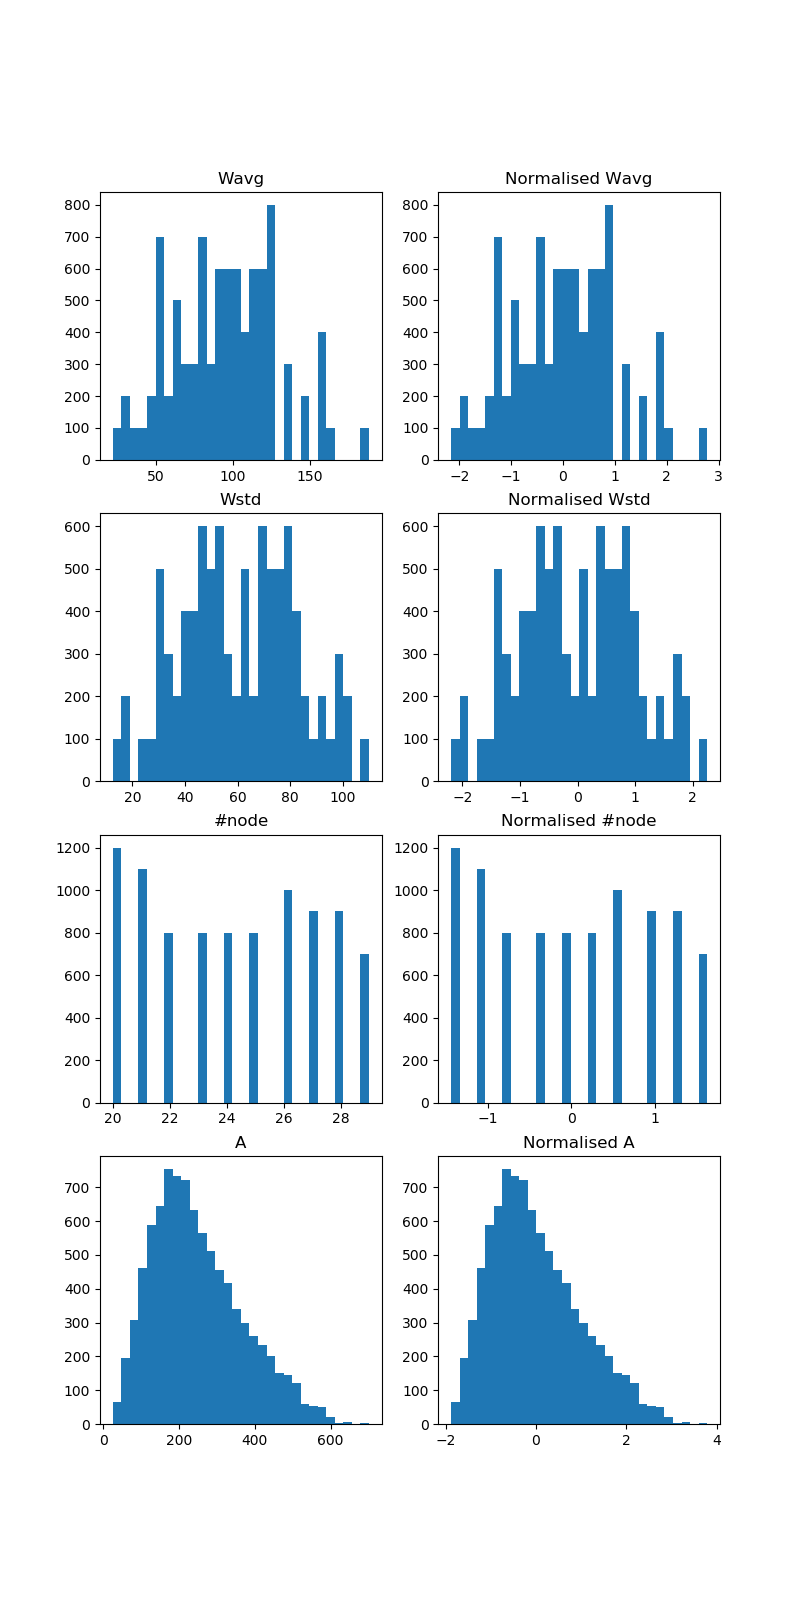

<IPython.core.display.Javascript object>


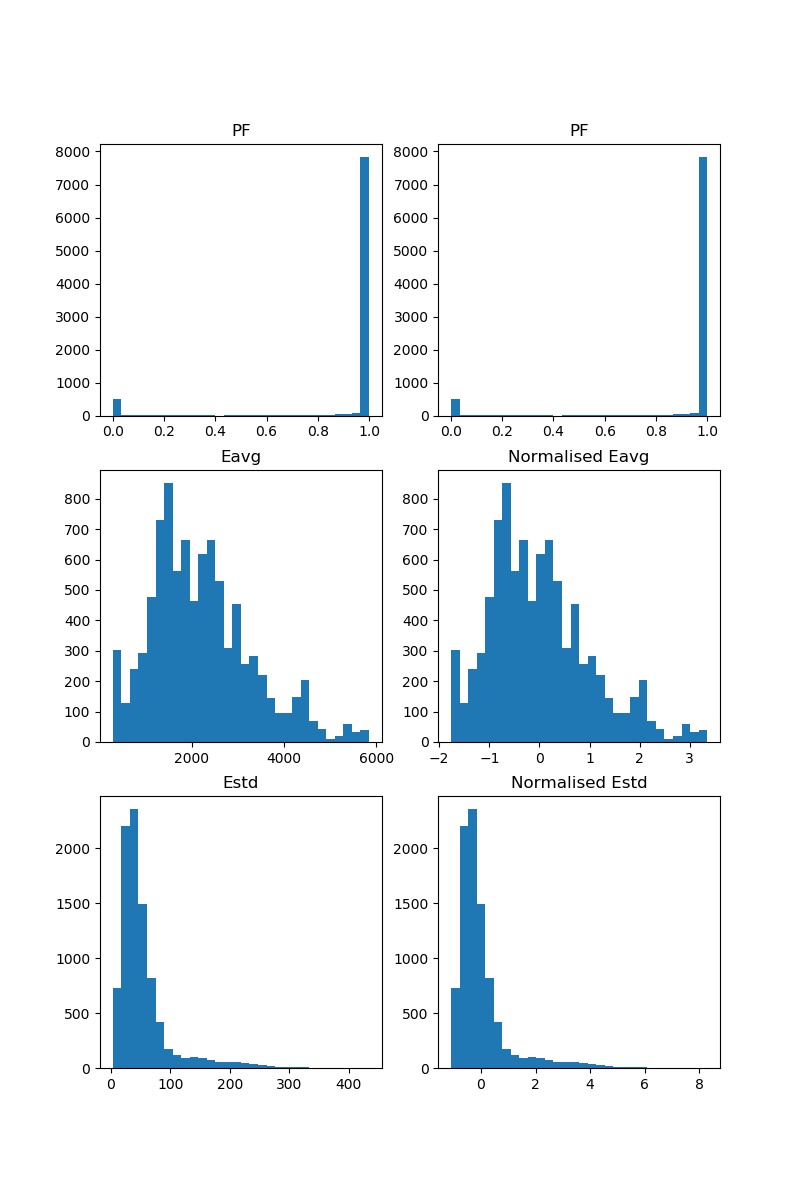

In [4]:
X_titles = ['Wavg', 'Wstd', '#node', 'A']
X_titles_transformed = ['Normalised Wavg', 'Normalised Wstd', 'Normalised #node', 'Normalised A']
Y_titles = ['PF', 'Eavg', 'Estd']
Y_titles_transformed = ['PF', 'Normalised Eavg', 'Normalised Estd']

X = np.asarray([d['input'][0] for d in train_dataset])
Y = np.asarray([d['target'][0] for d in train_dataset])

fig, axs = plt.subplots(4,2,figsize=(8,16))

for i in range(X.shape[1]):
    axs[i][0].hist(scalerx.inverse_transform(X)[:,i], bins=30)
    axs[i][0].set_title(X_titles[i])
    axs[i][1].hist(X[:,i], bins=30)
    axs[i][1].set_title(X_titles_transformed[i])
    
fig, axs = plt.subplots(3,2,figsize=(8,12))

for i in range(Y.shape[1]):
    axs[i][0].hist(transform.inverse_transform_Y(Y)[:,i], bins=30)
    axs[i][0].set_title(Y_titles[i])
    axs[i][1].hist(Y[:,i], bins=30)
    axs[i][1].set_title(Y_titles_transformed[i])

<IPython.core.display.Javascript object>


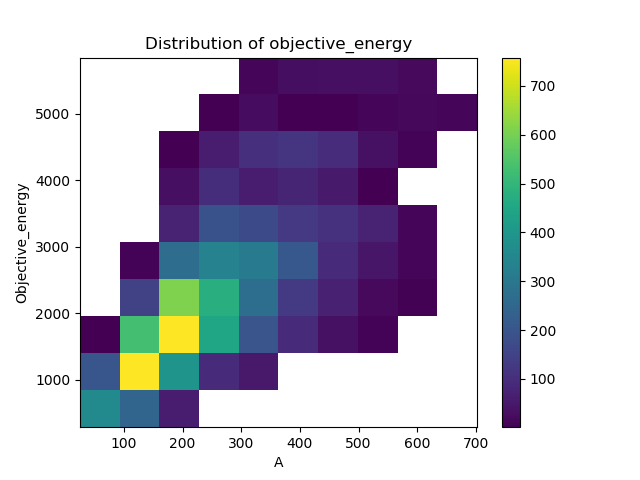

In [5]:
train_dataset = Feat3Dataset(adj_path=train_adj_path, da_path=train_da_path)
X = np.asarray([d['input'][0] for d in train_dataset])
Y = np.asarray([d['target'][0] for d in train_dataset])

# plot heatmap, in which x axis is A, y axis is obj_energy,
# color scale is the frequency of the bin
heatmap, xedges, yedges = np.histogram2d(X[:,-1], Y[:, 1])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

heatmap[heatmap==0]=np.NaN
plt.figure()
plt.imshow(heatmap.T, extent=extent, origin='lower', aspect='auto')
plt.colorbar()
plt.title('Distribution of objective_energy')
plt.xlabel('A')
plt.ylabel('Objective_energy')
plt.show()

The figure above is a 2D histogram of objective energy. The color scale of each pixel represents the number of data instances for a given (A, obj_energy) that fall into the bin.

<IPython.core.display.Javascript object>


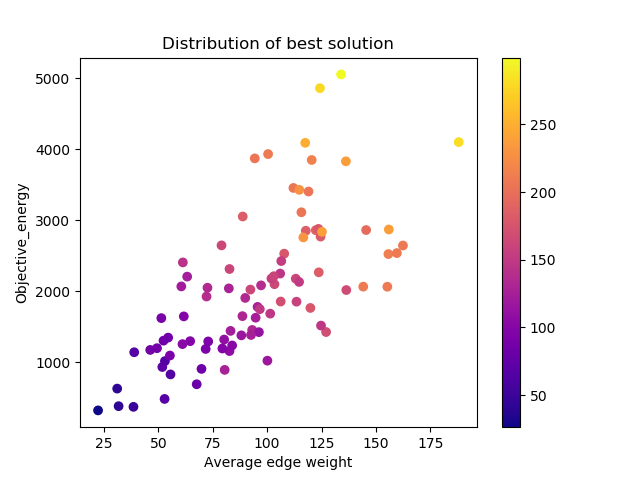

In [6]:
# Distribution of the best solution

train_dataset = Feat3Dataset(adj_path=train_adj_path, da_path=train_da_path)
X = np.asarray([d['input'][0] for d in train_dataset.bestSet(0.5)])
Y = np.asarray([d['target'][0] for d in train_dataset.bestSet(0.5)])

plt.figure()
plt.title('Distribution of best solution')
plt.xlabel('Average edge weight')
plt.ylabel('Objective_energy')

# plot_x, plot_y = a_ew_set[min_obj_energy>0,:], min_obj_energy[min_obj_energy>0]
plt.scatter(X[:,0], Y[:,1], c=X[:,-1], cmap='plasma')

plt.colorbar()
plt.show()

Here "best" stands for the minimum objective energy (feasible) for a given graph. The color scale of a point represent the value of corresponding A.
  
For simlar average edge weight, the minimum objective energy and corresponding A can be different. That means there are something else besides average edge weight, e.g. topology of graph, affects the choice of A and the best solution.

### Decision boundary

Given a graph, what As are not feasible?

<IPython.core.display.Javascript object>


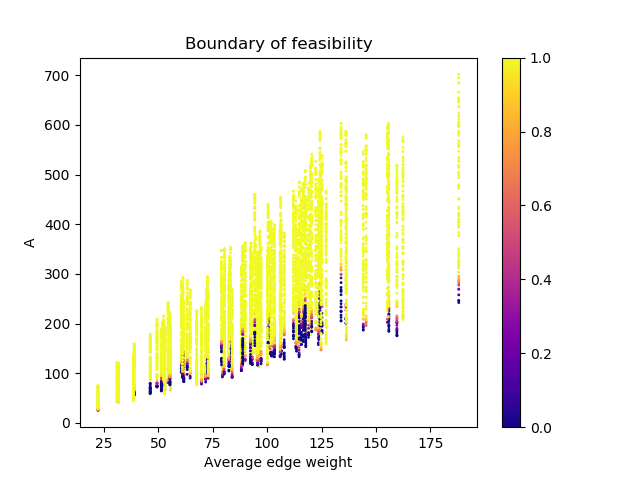

In [7]:
X = np.asarray([d['input'][0] for d in train_dataset])
Y = np.asarray([d['target'][0] for d in train_dataset])

f, ax = plt.subplots()
im = ax.scatter(X[:,0], X[:,-1], c=Y[:,0], cmap='plasma', s=1)
ax.set_title('Boundary of feasibility')
ax.set_xlabel('Average edge weight')
ax.set_ylabel('A')
# color stands for PF
f.colorbar(im)
plt.show()

In [8]:
train_dataset = Feat3Dataset(adj_path=train_adj_path, da_path=train_da_path)
X = np.asarray([d['input'][0] for d in train_dataset])
Y = np.asarray([d['target'][0] for d in train_dataset])
scalerx = StandardScaler().fit(X)
scalery = StandardScaler().fit(Y)
transform = FeatTransformer(scalerx, scalery)
train_dataset = Feat3Dataset(adj_path=train_adj_path, da_path=train_da_path, transform=transform)

test_dataset = Feat3Dataset(adj_path=test_adj_path, da_path=test_da_path, transform=transform)

### How big is the training set and test set?

In [9]:
print('\tDimenison of training dataset : ', len(train_dataset))
print('\tDimension of test dataset: ', len(test_dataset))

	Dimenison of training dataset :  9000
	Dimension of test dataset:  1000


### Predict probability of feasibility and objective energy

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randfloat
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit
from scipy.special import logit as sp_logit
from scipy.special import expit as sp_expit
import os.path
import pickle

AVG_ENERGY_MODEL = ['LR_avg_energy.model',
                'MLPR_avg_energy.model',
                'GBR_avg_energy.model',
               ]

STD_ENERGY_MODEL = ['LR_std_energy.model',
                'MLPR_std_energy.model',
                'GBR_std_energy.model',
               ]

PROB_MODEL = ['LR_prob.model',
              'MLPR_prob.model',
              'GBR_prob.model',
             ]

X = np.asarray([d['input'][0] for d in train_dataset])
Y = np.asarray([d['target'][0] for d in train_dataset])
group_train = train_dataset.getGroup()

In [11]:
from sklearn.linear_model import LinearRegression

def getLinearRegression(X, Y, name='LinearRegression.model', regenerate=False):

    if os.path.isfile(name) and not regenerate:
        model = pickle.load(open(name, "rb"))
    else:
        model = LinearRegression()
        model.fit(X, Y)
        pickle.dump(model, open(name, "wb"))
    
    return model

model = getLinearRegression(X, Y[:,0], PROB_MODEL[0], )
model = getLinearRegression(X, Y[:,1], AVG_ENERGY_MODEL[0], )
model = getLinearRegression(X, Y[:,2], STD_ENERGY_MODEL[0], )

In [12]:
from sklearn.neural_network import MLPRegressor

def getMLPRegressor(X, Y, name='MLPRegressor.model', regenerate=False):

    if os.path.isfile(name) and not regenerate:
        model = pickle.load(open(name, "rb"))
    else:
        gss = GroupShuffleSplit(n_splits=3, test_size=0.1, random_state=1)
        
        parameters = {
            'hidden_layer_sizes': [(sp_randint.rvs(5,100,1),sp_randint.rvs(2,50,1),),],
            'activation': ['tanh', 'relu', 'logistic'],
            'solver': ['sgd', 'adam', 'lbfgs'],
            'alpha': sp_randfloat(0.0001, 0.9),
            'learning_rate': ['constant','adaptive']
        }
        
        model = RandomizedSearchCV(estimator=MLPRegressor(random_state=1),
                                   param_distributions = parameters, 
                                   cv = gss,
                                   n_iter = 10,
                                   n_jobs=-1)

        model.fit(X, Y, groups=group_train)

        pickle.dump(model, open(name, "wb"))
        return model

model = getMLPRegressor(X, Y[:,0], PROB_MODEL[1], )
model = getMLPRegressor(X, Y[:,1], AVG_ENERGY_MODEL[1], )
model = getMLPRegressor(X, Y[:,2], STD_ENERGY_MODEL[1], )

/home/huangtian/miniconda3/envs/digiplex/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [13]:
from sklearn.ensemble import GradientBoostingRegressor

def getGradientBoostingRegressor(X, Y, name='GradientBoostingRegressor.model', regenerate=False):

    if os.path.isfile(name) and not regenerate:
        model = pickle.load(open(name, "rb"))
    else:
        gss = GroupShuffleSplit(n_splits=3, test_size=0.1, random_state=1)
        
        parameters = {'learning_rate': sp_randfloat(),
                      'subsample'    : sp_randfloat(),
                      'n_estimators' : sp_randint(100, 500),
                      'max_depth'    : sp_randint(1, 10) 
                     }

        model = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=1),
                                   param_distributions = parameters, 
                                   cv = gss,
                                   n_iter = 10,
                                   n_jobs=-1)

        model.fit(X, Y, groups=group_train)
        pickle.dump(model, open(name, "wb"))
        return model

model = getGradientBoostingRegressor(X, Y[:,0], PROB_MODEL[2], )
model = getGradientBoostingRegressor(X, Y[:,1], AVG_ENERGY_MODEL[2], )
model = getGradientBoostingRegressor(X, Y[:,2], STD_ENERGY_MODEL[2], )

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss

test_dataset = Feat3Dataset(adj_path=test_adj_path, da_path=test_da_path, transform=transform)
X = np.asarray([d['input'][0] for d in test_dataset])
Y = np.asarray([d['target'][0] for d in test_dataset])


preds_prob = {}
preds_avg = {}
preds_std = {}

for i in range(len(PROB_MODEL)):
    
    model_prob = pickle.load(open(PROB_MODEL[i], "rb"))
    model_avg_energy = pickle.load(open(AVG_ENERGY_MODEL[i], "rb"))
    model_std_energy = pickle.load(open(STD_ENERGY_MODEL[i], "rb"))
    
    print(PROB_MODEL[i], model_prob.score(X, Y[:,0]))
    print(AVG_ENERGY_MODEL[i], model_avg_energy.score(X, Y[:,1]))
    print(STD_ENERGY_MODEL[i], model_std_energy.score(X, Y[:,2]))
    print()

    Y_pred = np.vstack([model_prob.predict(X),
                        model_prob.predict(X),
                        model_std_energy.predict(X),
                       ]).T

    Y_pred = transform.inverse_transform_Y(Y_pred)
    
    preds_prob[PROB_MODEL[i]] = Y_pred[:,0]
    preds_avg[AVG_ENERGY_MODEL[i]] = Y_pred[:,1]
    preds_std[STD_ENERGY_MODEL[i]] = Y_pred[:,2]

Y_test = transform.inverse_transform_Y(Y)

LR_prob.model 0.22906918820634703
LR_avg_energy.model 0.7281784174989685
LR_std_energy.model 0.24548539348954246

MLPR_prob.model 0.5834528278078138
MLPR_avg_energy.model 0.6307767221037954
MLPR_std_energy.model 0.057636214743370544

GBR_prob.model 0.3325000809308585
GBR_avg_energy.model 0.2965509036173348
GBR_std_energy.model 0.13743772097067652



<IPython.core.display.Javascript object>


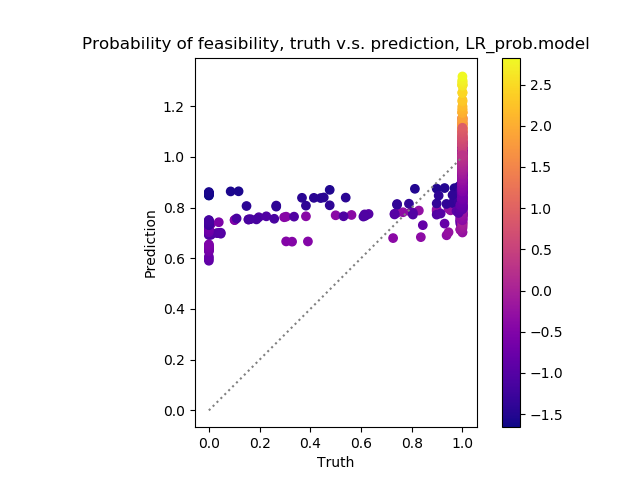

MSE LR_prob.model 0.049270189539683484


<IPython.core.display.Javascript object>


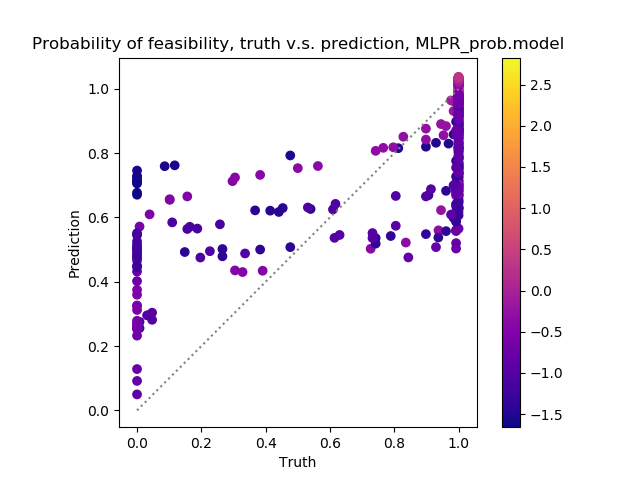

MSE MLPR_prob.model 0.026621530508526958


<IPython.core.display.Javascript object>


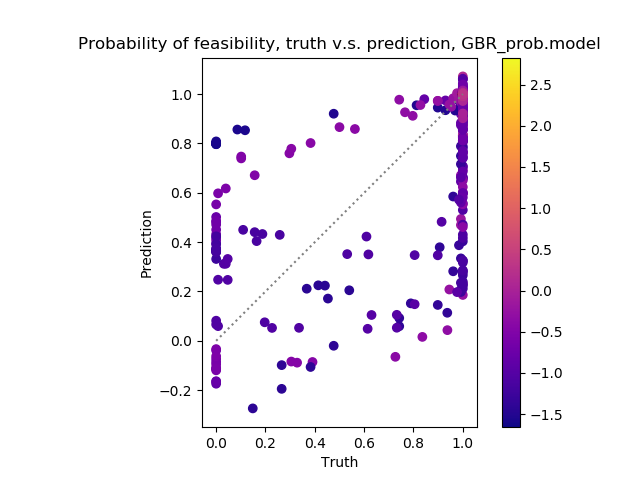

MSE GBR_prob.model 0.042659921003472275


In [21]:
# from matplotlib import lines as mlines

# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# ax.set_title('Probability of feasibility, truth v.s. prediction')
# ax.set_xlabel('Truth')
# ax.set_ylabel('Prediction')
# ax.add_line(mlines.Line2D([0,1], [0,1], color='grey', ls=':'))

# for i, (key, val) in enumerate(preds_prob.items()):
#     ax.scatter(Y_test_prob, val, label=key, alpha=0.4)
#     print('MSE',key, mean_squared_error(Y_test_prob, val))

# ax.legend()

from matplotlib import lines as mlines

for i, (key, val) in enumerate(preds_prob.items()):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_title('Probability of feasibility, truth v.s. prediction, '+key)
    ax.set_xlabel('Truth')
    ax.set_ylabel('Prediction')
    ax.add_line(mlines.Line2D([0,1], [0,1], color='grey', ls=':'))
    im = ax.scatter(Y_test[:,0], val, c=X[:,-1], cmap='plasma')
    fig.colorbar(im)
    print('MSE',key, mean_squared_error(Y_test[:,0], val))


<IPython.core.display.Javascript object>


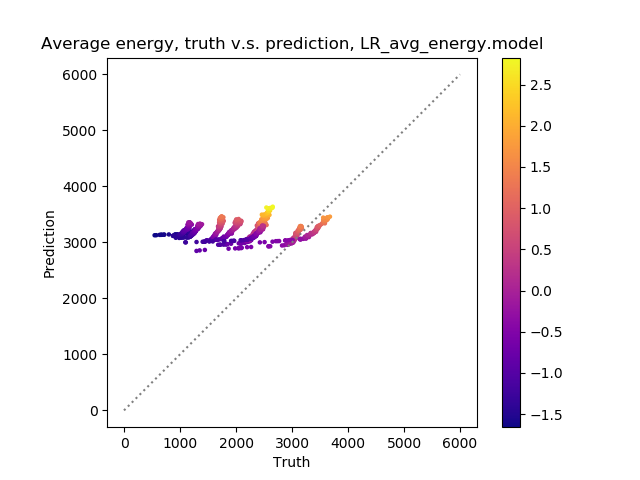

MSE LR_avg_energy.model 952.9334116252122


<IPython.core.display.Javascript object>


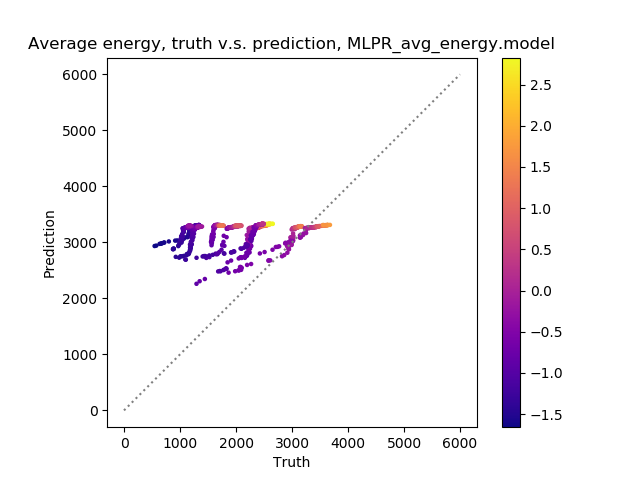

MSE MLPR_avg_energy.model 930.3242133906739


<IPython.core.display.Javascript object>


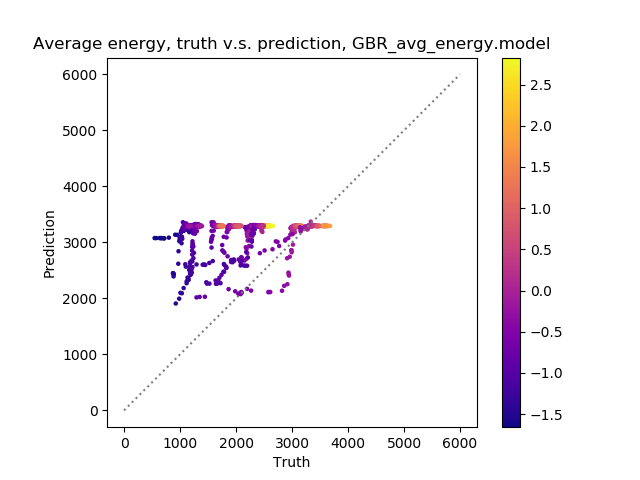

MSE GBR_avg_energy.model 911.1610055544159


In [23]:

from matplotlib import lines as mlines

for i, (key, val) in enumerate(preds_avg.items()):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_title('Average energy, truth v.s. prediction, ' + key)
    ax.set_xlabel('Truth')
    ax.set_ylabel('Prediction')
    ax.add_line(mlines.Line2D([0,6000], [0,6000], color='grey', ls=':'))
    im = ax.scatter(Y_test[:,1], val, c=X[:,-1], cmap='plasma', s=5)
    fig.colorbar(im)
    print('MSE', key, mean_squared_error(Y_test[:,1], val)/Y_test[:,1].mean())



<IPython.core.display.Javascript object>


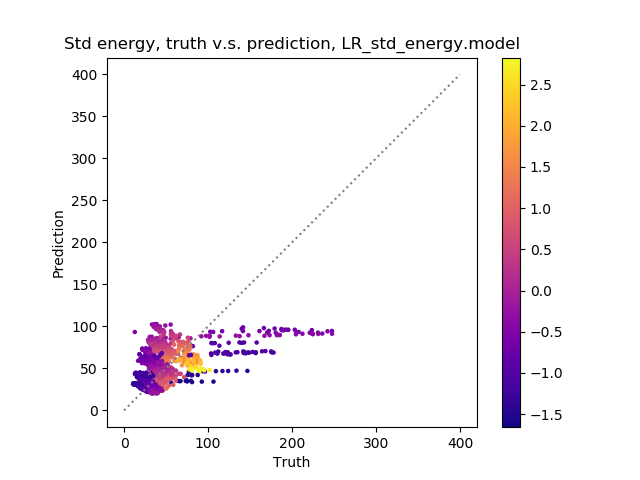

MSE LR_std_energy.model 21.663045728773213


<IPython.core.display.Javascript object>


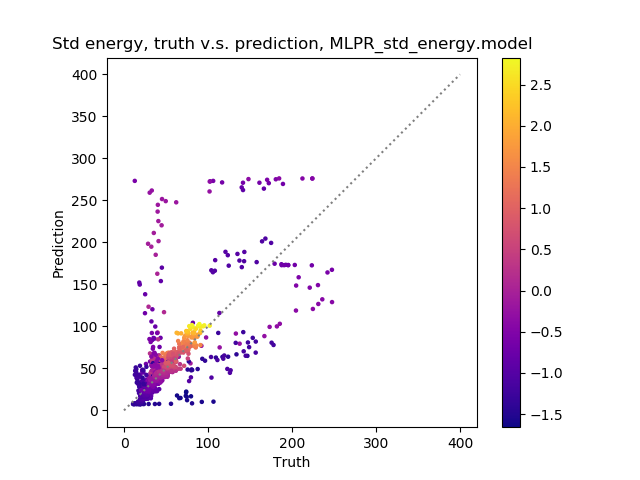

MSE MLPR_std_energy.model 27.05642753235585


<IPython.core.display.Javascript object>


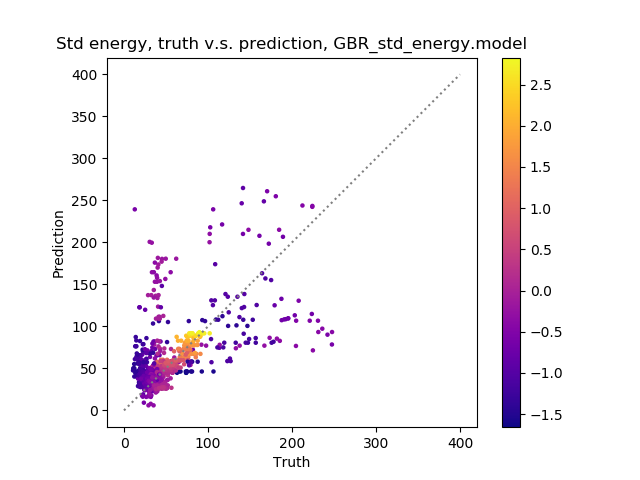

MSE GBR_std_energy.model 24.76522778127038


In [24]:
# from matplotlib import lines as mlines

# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# ax.set_title('Std energy, truth v.s. prediction')
# ax.set_xlabel('Truth')
# ax.set_ylabel('Prediction')
# ax.add_line(mlines.Line2D([0,400], [0,400], color='grey', ls=':'))

# for i, (key, val) in enumerate(preds_std.items()):
#     ax.scatter(Y_test_std, val, label=key, alpha=0.4)
#     print('MSE', key, mean_squared_error(Y_test_std, val)/np.square(Y_test_std).sum())

# ax.legend()

from matplotlib import lines as mlines


for i, (key, val) in enumerate(preds_std.items()):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_title('Std energy, truth v.s. prediction, '+key)
    ax.set_xlabel('Truth')
    ax.set_ylabel('Prediction')
    ax.add_line(mlines.Line2D([0,400], [0,400], color='grey', ls=':'))
    im = ax.scatter(Y_test[:,2], val, c=X[:,-1], cmap='plasma', s=5)
    fig.colorbar(im)
    print('MSE', key, mean_squared_error(Y_test[:,2], val)/Y_test[:,2].mean())




### The final goal: given graph, find the best A with specified probability of feasibility

In [37]:
# from scipy.optimize import minimize as sp_minimize
from scipy.optimize import shgo as sp_shgo
# from scipy.optimize import differential_evolution as sp_de

def predict_A(model_energy, model_prob, x, p):
    """ Find the best A by finding the lowest objective energy,
        given constrain on probability of feasibility
            model_energy: regression model, predict energy
            model_prob: regression model, predict probability of feasibility
            x: 1D array, (avg, std, #node)
            p: probability of feasibility
    """

    def func(a):
        if np.isnan(a):
            return np.nan
        input_transformed = scalerx.transform(np.hstack([x,a]).reshape(1,-1))
        return model_energy.predict(input_transformed).flatten()[0]
    
    def cons(a):
        if np.isnan(a):
            return np.nan
        input_transformed = scalerx.transform(np.hstack([x,a]).reshape(1,-1))
        _prob_pred = model_prob.predict(input_transformed).flatten()[0]
        _prob_pred = sp_expit(_prob_pred)
        return _prob_pred - p
    
    if np.isnan(x).any():
        return None
    
    bnds = [(0,(x[0]+x[1]*3)*2)]

    res = sp_shgo(func, bnds, constraints={'fun':cons, 'type':'ineq'})
#     res = sp_minimize(func, (x[0]), constraints={'fun':cons, 'type':'ineq'})
    if res.success:
        return res.x[0]
    else:
        return None

def lookup(ds, x, a):
    """ Given a graph and A, search in the original dataset and 
    return the closest data instance with its probability, average
    objective energy and std objective energy
    """
    
    def lookup_graph(ds_x, x):
        ds_unique = np.unique(ds_x[:,:-1], axis=0)
        i = np.argmin(np.square(ds_unique-x).sum(axis=-1))
        return ds_x[:,0]==ds_unique[i,0]
    
    def lookup_a(subset, a):
        i = np.argmin(np.abs(subset[:,-1]-a))
        return i

    ds_x = np.asarray([data['input'][0] for data in ds])
    ds_y = np.asarray([data['target'][0] for data in ds])
    idx = lookup_graph(ds_x, x)
    subset_x = ds_x[idx, :]
    subset_y = ds_y[idx, :]
    idx = lookup_a(subset_x, a)
    
    return subset_y[i,:]


In [45]:
test_dataset = Feat3Dataset(adj_path=test_adj_path, da_path=test_da_path)

preds_a = {}
preds_obj = {}

truths_a = {}
truths_obj = {}

for j in range(len(AVG_ENERGY_MODEL)):
    model_energy = pickle.load(open(AVG_ENERGY_MODEL[j], "rb"))
    model_prob = pickle.load(open(PROB_MODEL[j], "rb"))
    pred_a = []
    pred_obj = []
    truth_a = []
    truth_obj = []
    for data in test_dataset.bestSet(0.5):
        X = data['input'][0]
        Y = data['target'][0]
        res = predict_A(model_energy, model_prob, X[:-1], 0.5)
        if res is None:
            pred_a.append(np.nan)
            pred_obj.append([np.nan, np.nan, np.nan])
        else:
            pred_a.append(res)
            pred_obj.append(lookup(test_dataset, X[:-1], pred_a[-1]))

        truth_a.append(X[-1])
        truth_obj.append(Y)
        
    preds_a[AVG_ENERGY_MODEL[j]] = pred_a
    preds_obj[AVG_ENERGY_MODEL[j]] = np.asarray(pred_obj)
    truths_a[AVG_ENERGY_MODEL[j]] = truth_a
    truths_obj[AVG_ENERGY_MODEL[j]] = np.asarray(truth_obj)
    
for i, (key, val) in enumerate(preds_a.items()):
    print(key, np.isnan(val).sum(), ' out of ', len(val), ' are unsuccessfull')

LR_avg_energy.model 0  out of  10  are unsuccessfull
MLPR_avg_energy.model 0  out of  10  are unsuccessfull
GBR_avg_energy.model 0  out of  10  are unsuccessfull


<IPython.core.display.Javascript object>


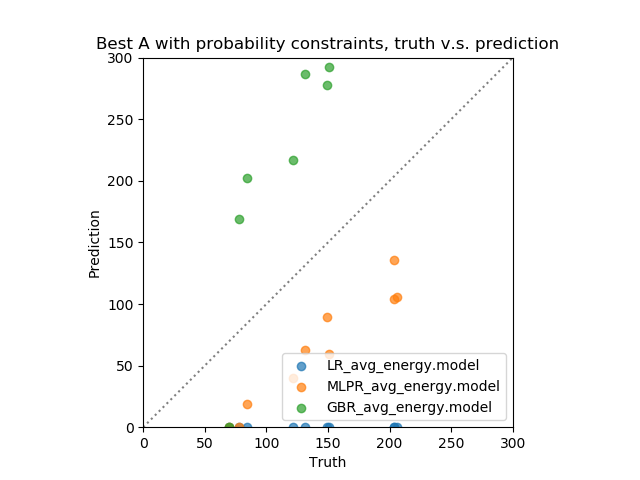

In [46]:
from matplotlib import lines as mlines

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_title('Best A with probability constraints, truth v.s. prediction')
ax.set_xlabel('Truth')
ax.set_ylabel('Prediction')
ax.add_line(mlines.Line2D([0,600], [0,600], color='grey', ls=':'))

for i, (key, val) in enumerate(preds_a.items()):
    ax.scatter(truths_a[key], val, label=key, alpha=0.7)
ax.set_xlim([0,300])
ax.set_ylim([0,300])
ax.legend()

<IPython.core.display.Javascript object>


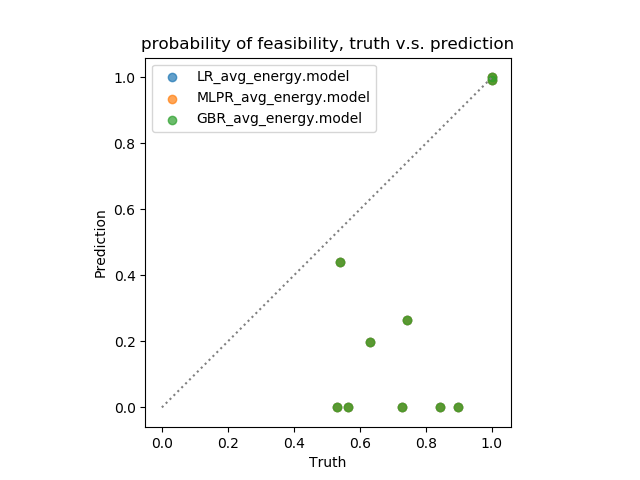

In [47]:
from matplotlib import lines as mlines

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_title('probability of feasibility, truth v.s. prediction')
ax.set_xlabel('Truth')
ax.set_ylabel('Prediction')
ax.add_line(mlines.Line2D([0,1], [0,1], color='grey', ls=':'))

target_index=0

for i, (key, val) in enumerate(preds_obj.items()):
    ax.scatter(truths_obj[key][:,target_index], val[:,target_index], label=key, alpha=0.7)
ax.legend()

<IPython.core.display.Javascript object>


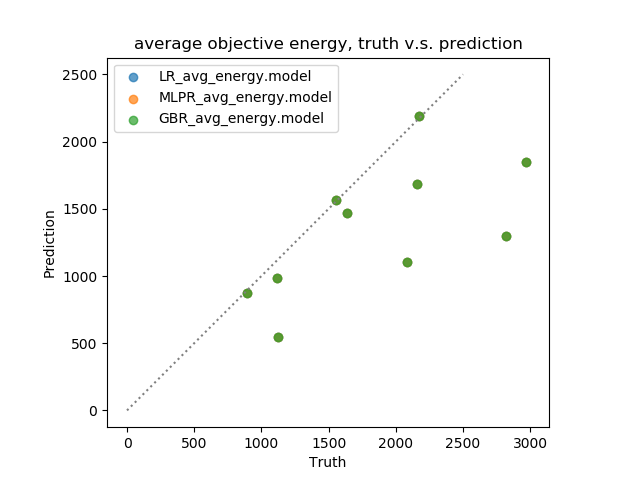

In [48]:
from matplotlib import lines as mlines

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_title('average objective energy, truth v.s. prediction')
ax.set_xlabel('Truth')
ax.set_ylabel('Prediction')
ax.add_line(mlines.Line2D([0,2500], [0,2500], color='grey', ls=':'))

target_index=1

for i, (key, val) in enumerate(preds_obj.items()):
    ax.scatter(truths_obj[key][:,target_index], val[:,target_index], label=key, alpha=0.7)
ax.legend()

<IPython.core.display.Javascript object>


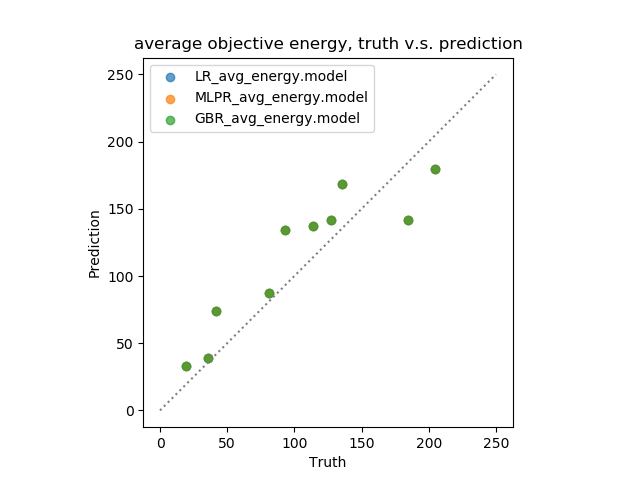

In [49]:
from matplotlib import lines as mlines

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_title('average objective energy, truth v.s. prediction')
ax.set_xlabel('Truth')
ax.set_ylabel('Prediction')
ax.add_line(mlines.Line2D([0,250], [0,250], color='grey', ls=':'))

target_index=2

for i, (key, val) in enumerate(preds_obj.items()):
    ax.scatter(truths_obj[key][:,target_index], val[:,target_index], label=key, alpha=0.7)
ax.legend()